In [1]:
import re
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%pylab inline
import sklearn.datasets
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import nltk
# from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")


Populating the interactive namespace from numpy and matplotlib


In [2]:
def print_head(lines, n) :
    print (len(lines))
    for i in range(n) :
        print (lines[i])

In [3]:
def hasDigits(inputString):
    for char in inputString:
        if char.isdigit() :
            return True
        
    return False

In [4]:
stemmer = SnowballStemmer("english")
pos_words = list()
with open('positive_words.txt', 'r') as f0:
    for line in f0:
        pos_words.append(stemmer.stem( line.rstrip() ) )

positive_words = list(set(pos_words))

# print (len(positive_words) )

neg_words = list()
with open('negative_words.txt', 'r') as f1:
    for line in f1:
        # print (line)
        neg_words.append(stemmer.stem( line.rstrip() ) )
        
negative_words = list(set(neg_words))
# print (len(negative_words) )

In [65]:
# cachedStopWords = stopwords.words("english")

def to_vw_format(line, label=None):
    bad_words = re.findall('\w{2,}', line.lower())
    mood = 0
    words = list()
    for w in bad_words:
        if ( not hasDigits(w) ) : # and (w not in cachedStopWords ) :
            w = stemmer.stem(w)
            # w = w.encode('ascii', 'ignore')
            
            if w in positive_words :
                mood += 1
            if w in negative_words :
                mood -= 1
            
  
            words.append(w)
            #print (words)
        
    if mood > 2 :
        am = 'good '
    elif mood < -2 :
        am = 'bad '
    else :
        am = 'unsure '
                
                        
    return str(label or '') + ' |text ' + am  + ' '.join(words) +  '\n'

In [66]:
def read_train_file(filename) :
    vw_lines = list()
    vw_labels = list()
    with open(filename, 'r') as fp:
        for line in fp:
            label = 1 if int(line[-2:]) == 1 else -1
            vw_lines.append(to_vw_format(line, label))
            vw_labels.append(label)
    return vw_lines, vw_labels

In [67]:
train_lines, train_codes = read_train_file('products_sentiment_train.tsv')

In [68]:
train_docs, test_docs, train_labels, test_labels = train_test_split(train_lines, train_codes, 
                                                                              stratify=train_codes,
                                                                              test_size=0.1,
                                                                              random_state=7)

In [76]:
with open('sentiment_train.vw', 'w', encoding='utf-8') as f1:
    for line in train_docs :
        f1.write(line)
        
with open('sentiment_test.vw', 'w', encoding='utf-8') as f2:
    for line in test_docs:
        f2.write(line)

In [84]:
!vw --random_seed 7 --passes 20 -c -l 0.7 --decay_learning_rate 1.0 -d sentiment_train.vw --loss_function logistic --ngram 2 -f sentiment_model.vw

Generating 2-grams for all namespaces.
final_regressor = sentiment_model.vw
Num weight bits = 18
learning rate = 0.7
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
using cache_file = sentiment_train.vw.cache
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.0000       28
0.653961 0.614776            2            2.0  -1.0000  -0.1634       16
0.701623 0.749284            4            4.0   1.0000  -0.0889       10
0.693859 0.686095            8            8.0   1.0000  -0.1728       14
0.682894 0.671929           16           16.0  -1.0000   0.0352       34
0.647703 0.612512           32           32.0   1.0000   0.0784       10
0.611873 0.576044           64           64.0  -1.0000   0.1765       12
0.624560 0.637246          128          128.0  -1.0000   1.7043       

In [85]:
!vw -i sentiment_model.vw -t -d sentiment_test.vw -p sentiment_test_predictions.txt

Generating 2-grams for all namespaces.
only testing
predictions = sentiment_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = sentiment_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.689966 1.689966            1            1.0  -1.0000   0.3000       34
1.047141 0.404315            2            2.0   1.0000   1.6359       42
1.185471 1.323801            4            4.0   1.0000   0.7473       22
0.960933 0.736395            8            8.0  -1.0000  -0.0908        8
2.244924 3.528915           16           16.0   1.0000   3.6744       74
1.761560 1.278195           32           32.0  -1.0000  -0.3029       46
2.012303 2.263047           64           64.0   1.0000   0.6106       14
1.752082 1.491860          128          128.0   1.0000   0.8753       14

finished run
number of examples per

Загрузим полученные предсказания, вычислим AUC и отобразим ROC-кривую:

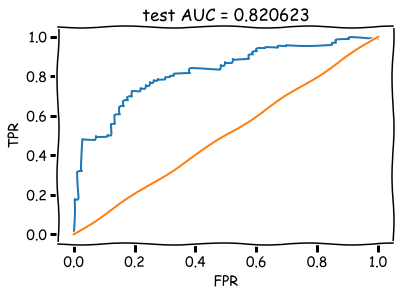

In [86]:
with open('sentiment_test_predictions.txt') as f3:
    test_prediction = [float(label) 
                             for label in f3.readlines()]

auc = sklearn.metrics.roc_auc_score(test_labels, test_prediction)
roc_curve = sklearn.metrics.roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); 
    plt.title('test AUC = %f' % (auc)); 
    plt.axis([-0.05,1.05,-0.05,1.05]);

In [87]:
def read_test_file(filename) :
    test_text = list()
    first = True
    with open(filename, 'r') as fp:
        for line in fp:
            if (first) :
                first = False
                continue
            test_text.append(to_vw_format(line,1))
            
    return test_text

In [88]:
full_test_lines = read_test_file('products_sentiment_test.tsv')

In [89]:
with open('sentiment_full_test.vw', 'w', encoding='utf-8') as f3:
    for line in full_test_lines :
        f3.write(line)

In [90]:
with open('sentiment_full_train.vw', 'w', encoding='utf-8') as f4:
    for line in train_lines :
        f4.write(line)

In [92]:
!vw -l 0.8 --decay_learning_rate 1.0 -d sentiment_full_train.vw --loss_function logistic --ngram 2  -f sentiment_model.vw

Generating 2-grams for all namespaces.
final_regressor = sentiment_model.vw
Num weight bits = 18
learning rate = 0.8
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = sentiment_full_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0   1.0000   0.0000        8
0.612562 0.531977            2            2.0   1.0000   0.3534       44
0.710547 0.808533            4            4.0  -1.0000   0.7477       60
0.536247 0.361947            8            8.0   1.0000   1.2814       64
0.628955 0.721662           16           16.0  -1.0000   0.8464       22
0.708683 0.788412           32           32.0   1.0000  -0.1502       46
0.652677 0.596671           64           64.0   1.0000   1.2736       40
0.630859 0.609040          128          128.0   1.0000  -0.1611       62
0.627772 0.624686          256          256.0   1.0

In [93]:
!vw -i sentiment_model.vw -t -d sentiment_full_test.vw -p sentiment_full_predictions.txt

Generating 2-grams for all namespaces.
only testing
predictions = sentiment_full_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = sentiment_full_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
5.077186 5.077186            1            1.0   1.0000   3.2533       58
4.779863 4.482540            2            2.0   1.0000  -1.1172       38
2.423926 0.067990            4            4.0   1.0000   0.6717       18
3.670571 4.917215            8            8.0   1.0000  -1.1780       72
2.915589 2.160606           16           16.0   1.0000   0.7376       22
3.610224 4.304859           32           32.0   1.0000   0.6166       24
2.780837 1.951451           64           64.0   1.0000  -0.5040       14
2.385895 1.990953          128          128.0   1.0000   2.5779       26
2.342951 2.300006          256 

In [94]:
predictions = list()
with open('sentiment_full_predictions.txt', 'r') as f6:
    for line in f6:
        pr = int(float(line) > 0) 
        predictions.append(pr)
        

In [95]:
with open('sokolovdp_sentiment_summission.txt', 'w', encoding='utf-8') as f5:
    f5.write("Id,y\n")
    for i, pr in enumerate(predictions) :
        f5.write("%d,%d\n"% (i, pr) )

# check mood scores

In [94]:
scores = list()
with open('sentiment_full_test.vw', 'r') as f9:
    for line in f9:
        score = int(line[7:10])
        if score > 0 :
            score = 1 
        else :
            score = 0
        scores.append( score )


In [95]:
with open('sokolovdp_sentiment_summission.txt', 'w', encoding='utf-8') as f5:
    f5.write("Id,y\n")
    for i, pr in enumerate(scores) :
        f5.write("%d,%d\n"% (i, pr) )